# DABN13 - Assignment 7

## Part 1: Canned procedures for p-value adjustment
In this part we are going to explore which variables are relevant for first run U.S. box office ($) sales, for a set of 62 movies.
We have 12 explanatory variables:

* MPRating = MPAA Rating code, 1=G, 2=PG, 3=PG13, 4=R,
* Budget = Production budget ($Mil),
* Starpowr = Index of star poser,
* Sequel = 1 if movie is a sequel, 0 if not,
* Action = 1 if action film, 0 if not,
* Comedy = 1 if comedy film, 0 if not,
* Animated = 1 if animated film, 0 if not,
* Horror = 1 if horror film, 0 if not,
* Addict = Trailer views at traileraddict.com,
* Cmngsoon = Message board comments at comingsoon.net,
* Fandango = Attention at fandango.com (see Example 4.12),
* Cntwait3 = Percentage of Fandango votes that can't wait to see



In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import os

os.chdir("C:/Users/claes/OneDrive/Universitet/DataScience Magisterprogram/STAN51 - Maskininlärning ur ett regressionperspektiv/Inlamningar/Inlamning_7")

movie_data = pd.read_csv("movie_buzz.txt")

movie_data.head()

,BOX,MPRATING,BUDGET,STARPOWR,SEQUEL,ACTION,COMEDY,ANIMATED,HORROR,ADDICT,CMNGSOON,FANDANGO,CNTWAIT3
0,19167085,4,28.0,19.83,0,0,1,0,0,7860.50,10,144,0.49
1,63106589,2,150.0,32.69,1,0,0,1,0,5737.00,59,468,0.79
2,5401605,4,37.4,15.69,0,0,1,0,0,850.00,24,198,0.36
3,67528882,3,200.0,23.62,1,1,0,0,0,15326.00,93,1778,0.76
4,26223128,2,150.0,19.02,0,0,0,1,0,4574.25,30,1109,0.53


### Task 1a)

We want to train a linear regression model with the *logarithm* of box office sales as output and all other variables in `movie_data` (plus a constant) as inputs. We are not going to hold out any validation data. 

First, extract the output and input variables into $n \times 1$ and $n \times p$ NumPy arrays `y_1a` and `X_1a`, respectively. Second, use the `OLS()` function in `statsmodels` to specify the regression model and to learn its coefficients. Save the specified model as `lm_fit_1a`. Third, save the p-values of tests for the individual significance of the regression coefficients as `pvalues_1a`. 

*Hint:* Information about where the p-values of a learned linear regression can be found is provided by the [documentation](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html#statsmodels.regression.linear_model.RegressionResults) of the `RegressionResults()` class in `statsmodels`.

In [2]:
# 1.
y_1a = np.log(movie_data.iloc[:, 0].values.reshape(-1, 1)) # Logarithm of the original response variable
X_1a = sm.add_constant(movie_data.iloc[:,1:]) # Explanatory variables as well as adding of a constant.

# 2.
lm_fit_1a = sm.OLS(y_1a,X_1a).fit()
print(lm_fit_1a.summary())

# 3.
pvalues_1a = lm_fit_1a.pvalues
print(pvalues_1a)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     6.554
Date:                Mon, 30 Oct 2023   Prob (F-statistic):           8.52e-07
Time:                        11:51:01   Log-Likelihood:                -54.149
No. Observations:                  62   AIC:                             134.3
Df Residuals:                      49   BIC:                             162.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.2537      0.598     25.512      0.0

In [3]:
import statsmodels.stats.multitest as smm

alpha_1b = 0.05

# 1.
p_holm_1b = smm.multipletests(
    pvalues_1a, 
    alpha=alpha_1b, 
    method='holm', 
    maxiter=1, 
    is_sorted=False, 
    returnsorted=False
)

# 2.
names_selected_1b = X_1a.columns[p_holm_1b[0]]
print(names_selected_1b)

Index(['const', 'CNTWAIT3 '], dtype='object')


## Part 2: The FWER in a simulation study

In this part, we will use simulations to convince ourselves that standard p-values are problematic if we conduct a larger number of tests and that simple p-value adjustments can address our multiple testing problem.

Below, I have written a short function `X_fun_precompute` that calculates particular functions of some provided matrix `XX`. These are returned as a dictionary. We will need this function output in the tasks below.


In [4]:
def X_fun_precompute(XX):
    p1        = XX.shape[1]
    XtX       = XX.T @ XX
    XtX_inv   = np.linalg.solve(XtX, np.eye(p1))
    XtX_inv_Xt = XtX_inv @ XX.T  
    results = {'X': XX,
               'XtX': XtX,
               'XtX_inv': XtX_inv,
               'XtX_inv_Xt': XtX_inv_Xt}
    return(results)

### Task 2a)
We start with the individual building blocks of our simulation study. First, we obtained learned coefficients, residuals and variance estimates from a linear regression model. Do the following:

1. Call the function `X_fun_precompute` with `X_1a` as its only argument and save the function output as `X_funs_2a`.
2. Manually compute the learned coefficients in a regression model with `y_1a` as output and `X_1a` as inputs. Save it as `beta_hat_2a`. Use the pre-computed functions of `X_1a` inside `X_funs_2a` instead of constructing them again.  
3. Obtain the marginal variance 
$$ \widehat{Var}[\hat{\beta} | X, y]= \hat{\sigma}^{2}(X^TX)^{-1} $$
where $\hat{\sigma}^2$ is the estimated variance of the residuals. Save it as `VX_2a`. Again, use objects inside `X_funs_2a` to refer to `X_1a` and any function that involves `X_1a` alone. 

*Hint:* A good way to see that you have done things correctly is to compare your result with the summary of your regression results in Task 1a).

In [5]:
# 1.
X_funs_2a = X_fun_precompute(X_1a)

# 2.
beta_hat_2a = X_funs_2a['XtX_inv_Xt']@y_1a

# 3.
# sigma_hat_2 = (residuals.T@residuals) / (y_1a.shape[0]-np.trace(beta_hat_2a))
# np.var((X_1a@beta_hat_2a.values.reshape(-1).T - y_1a.reshape(-1)))

    # 1. Compute residuals
residuals = y_1a.reshape((y_1a.shape[0],)) - np.dot(X_1a, beta_hat_2a.values.reshape(13,))
    # 2. Compute sigma_squared for residuals
sigma_squared = (1 / (X_funs_2a['X'].shape[0] - X_funs_2a['X'].shape[1]-1)) * np.sum(residuals**2) # sum((observed value — predicted value)²) / (n — p — 1)

    # 3. Compute marginal varince error of each coefficient
VX_2a = np.diagonal(sigma_squared * X_funs_2a['XtX_inv'])


### Task 2b)

As a next step, do the following:

1. Obtain $t-$ statistics for $\beta_i$ under $H_0:\beta_i=0$, namely
$$
t_i = \left|\frac{\hat{\beta}_i}{\widehat{sd[\hat{\beta}_i | X, y]}} \right|,
$$
and save them as `t_2b`. Use existing objects from Task 2a to arrive there.
2. Compute the corresponding $p-$values of two-sided tests and save them as `pvalues_2b`. Here, keep in mind that $\frac{\hat{\beta}_i}{\widehat{sd[\hat{\beta}_i | X, y]}} $ follows a Student-t distribution with $n-p$ degrees of freedom. The cumulative density function of this distribution is given by the `t.cdf()` function in the stats-module of `scipy`. See its documentation [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html)

*Hint*: Use the result
$$
P_{0}(|T| \geq t) = P_{0}(T \leq -t)  + P_{0}(T \geq t).
$$


In [6]:
from scipy.stats import t

# 1.
t_2b       = np.abs( (np.array(beta_hat_2a).reshape(-1)) / np.sqrt(VX_2a) )

# 2.
pvalues_2b = 2*(1-t.cdf(t_2b, X_1a.shape[0]-X_1a.shape[1])) # 2 sided hence multiplied by 2.

print(pvalues_2b)

[0.00000000e+00 1.20416950e-01 1.03659607e-01 7.15676003e-01
 2.26780021e-01 1.10330452e-02 9.94789404e-01 4.09662062e-02
 2.30130413e-01 1.75183916e-01 9.02351524e-01 4.76220085e-01
 1.79042371e-04]


### Task 2c)
Now write a function `calculate_p_2c`.  Its arguments are a $n \times 1$ Numpy array of output values `y0` as well as a dictionary `X0_funs`  with the same structure as `X_funs_2a`. `calculate_p_2c` should conduct the same steps as in Tasks 2a-b and should return the p-values of a regression of `y0` on the input matrix from which `X0_funs` has been generated.

In [7]:
def calculate_p_2c(y0, X0_funs):
    # Step 1: Compute residuals
    residuals = y0 - np.dot(X0_funs['X'], X0_funs['XtX_inv_Xt'] @ y0)
    # Step 2: Compute sigma_squared for residuals
    N = X0_funs['X'].shape[0]
    p = X0_funs['X'].shape[1]
    sigma_squared = (1 / (N - p - 1)) * np.sum(residuals**2)

    # Step 3: Compute marginal variance error of each coefficient
    VX_2c = np.diagonal(sigma_squared * X0_funs['XtX_inv'])

    # Step 4: Calculate t-statistics
    beta_hat_2c = X0_funs['XtX_inv_Xt'] @ y0
    t_2c = np.abs( (np.array(beta_hat_2c).reshape(-1)) / np.sqrt(VX_2c) )

    # Step 5: Calculate p-values
    df = N - p # Degrees of freedom is needed to calculate the t-statistic.
    pvalues_2c = 2 * (1 - t.cdf(t_2c, df))

    return pvalues_2c


In [8]:
# Test to see if it works out, compare with the lm_fit
print(calculate_p_2c(y_1a, X_funs_2a))

[0.00000000e+00 1.20416950e-01 1.03659607e-01 7.15676003e-01
 2.26780021e-01 1.10330452e-02 9.94789404e-01 4.09662062e-02
 2.30130413e-01 1.75183916e-01 9.02351524e-01 4.76220085e-01
 1.79042371e-04]


### Task 2d)
Now we can set op our simulation study. Write a loop that repeats the following steps 1000 times:

1. Simulate an output `y_fake` unrelated to the existing inputs `X_1a`. `y_fake` should be drawn from a normal distribution with mean and variance coming from the sample mean and variance of the observed $y$ in your dataset.

2. Use your function `calculate_p_2c` to compute $p-$values in a linear regression of `y_fake` on the observed inputs `X_1a`. Use the existing dictionary `X_funs_2a` as second function argument.
3. Adjust the p-values returned by `calculate_p_2c` in two different ways: i) Bonferroni adjustment, ii) Holm's method.
4. Store the number of variables in the learned model (excluding the intercept) whose coefficient is found to be statistically significant at a significance level $\alpha=0.05$. Do this for i) p-value without adjustment, ii) Bonferroni-adjusted p-values, iii) Holm-adjusted p-values.

For step 3., create empty arrays, `n_selected_naive`, `n_selected_Holm` and `n_selected_Bonferroni` before you write the for loop. Inside the loop, store the number of statistically significant inputs in your *j*-th iteration in element *j* of these objects.

When the loop has finished, calculate the FWER using results from the 100 iterations of your loop. Save the FWER for your three sets of p-value based selection of significant predictors as `FWER_Naive`, `FWER_Holm` and `FWER_BF`.

Does either of the three methods successfully control the FWER? Save your answer in the string variable `FWER_control_2d`.

In [9]:

n_selected_naive, n_selected_Holm, n_selected_Bonferroni = [], [], [],

def new_func(y_fake):
    return calculate_p_2c(y_fake, X_funs_2a)

for i in range(1000): # I guess 1000, not very straightforward what he means
    
    y_fake = np.random.normal(loc=np.mean(y_1a), scale=np.std(y_1a), size = (y_1a.shape[0],1))
    inputs = sm.add_constant(X_1a)

    model = sm.OLS(y_fake,inputs).fit()

    calculated_p_2c = new_func(y_fake) 

    holms_p = smm.multipletests(
        calculated_p_2c, 
        alpha=0.05, 
        method='holm', 
        maxiter=1, 
        is_sorted=False, 
        returnsorted=False
    )
    bonferronis_p = smm.multipletests(
        calculated_p_2c, 
        alpha=0.05, 
        method='bonferroni', 
        maxiter=1, 
        is_sorted=False, 
        returnsorted=False
    )

    n_selected_naive.append(sum(calculated_p_2c[1:] < 0.05)) # Removes the intercept with [1:] since it not a varibale/coefficient we want to test
    n_selected_Holm.append(sum(holms_p[0][1:])), # Removes the intecept also for the Holms method
    n_selected_Bonferroni.append(sum(bonferronis_p[0][1:])) # And the same as for the Bonferroni method


print(np.sum(n_selected_naive) / len(n_selected_naive))
print(np.sum(n_selected_Holm) / len(n_selected_Holm))
print(np.sum(n_selected_Bonferroni) / len(n_selected_Bonferroni))

FWER_control_2d = "Based on running 1000 simulations we can see that both Bonferronni and Holm controls the family-wise error rate. Each falling beneath the choosen alpha-value of 0.05. (This can vary a little bit depending of which seed is run)."
print(FWER_control_2d)

0.545
0.044
0.041
Based on running 1000 simulations we can see that both Bonferronni and Holm controls the family-wise error rate. Each falling beneath the choosen alpha-value of 0.05. (This can vary a little bit depending of which seed is run).


## Part 3: Test power with p-value adjustment

Now that we have created an efficient algorithm for computing the p-values, we are going to explore what happens when one adds several signals to the simulated data.
However, we first rescale all input variables in our data so that they have a variance of one.

In [10]:
from sklearn.preprocessing import StandardScaler

scaler_3a = StandardScaler(with_mean=False) # With_mean makes sure we have (x-0)/s instead of (x-x_bar)/s.
X_3a      = scaler_3a.fit_transform(X_1a)

### Task 3a)
Next, we simulate artificial outcomes. However, in contrast to task 2d we are *not* creating new $y$ that are completely unrelated to the observed predictors in our box office sales data. More specifically, we simulate $y$ from the linear model
$$
\mathbf{y}= \mathbf{X}\boldsymbol{\beta} + \boldsymbol{\varepsilon}
$$
where $X$ contains the scaled predictors of Task 3a. For the vector of slope coefficients $\beta$, we let $\beta_{2:5}=log(2:5)$ whereas all other elements of this vector are 0. The model errors $\epsilon$ are drawn independently from a standard normal distribution. Construct a new object `y_sim_3a` that contains simulated outcomes from the model described here.

In [11]:
# signal_index_3a = [1, 2, 3, 4] # ? This is not B_2, B_3, B_4, B_5?
signal_index_3a = [np.arange(2, 6)]
betas = np.zeros(X_3a.shape[1])  # Initialize with zeros
betas[signal_index_3a] = np.log(np.arange(2, 6))     # Set elements 2 to 5 to log(2:5)

#np.random.seed(0)  # For reproducibility
epsilon = np.random.normal(0, 1, size=X_3a.shape[0])

# Calculate the simulated outcomes y_sim_3a
y_sim_3a = X_3a @ betas + epsilon

print("Betas: \n", betas)
print("\nSimulated y-values: \n", y_sim_3a)

Betas: 
 [0.         0.         0.69314718 1.09861229 1.38629436 1.60943791
 0.         0.         0.         0.         0.         0.
 0.        ]

Simulated y-values: 
 [ 4.61790824  9.67519361  3.24001271 12.76472179  6.58202733  1.86093877
  3.36138313  6.52948935  9.32372732  8.92055405  3.01669312  4.65307631
  7.75272978  2.8170205   3.80168863  5.37931866  4.63446383  3.892372
  6.66024428  6.74409685  5.66361815  7.75596486  3.76663915  1.84659498
  3.53073318  2.10217414  1.51241397  5.11986586  0.84249918  2.12712233
 -0.0418974   1.2537063   1.80840419 10.46355543 10.09664152  3.06983504
  6.23380207  3.45789456  3.52564462  6.48358436  4.07135039  6.10443446
  9.67129175  4.27638949  3.06859828  3.35779743  0.79672316  8.16858148
  1.7081327   7.6156648   9.46462287  0.07545673  1.28123057  6.8974447
  3.21689579  2.88156739  3.48737213  8.53094699  6.72364945  2.75782814
 12.31151046  2.06538974]


### Task 3b)
In this task were are getting adjusted p-values again:

1. Obtain a list object `x_funs_3b` containing functions of `X_3a` using `X_fun_precompute()`.
2. Use your`calculate_p_2c()` function to get p-values for significance tests in a regression with `y_sim_3a` as output and `X_3a` as inputs. Save your result as `pvalues_3b`.
2. Get adjusted p-values from Bonferroni and Benjamini & Hochberg corrections by using `p.adjust()`. Save these p-values as `p_BF_3b` and `p_hochberg_3b`.

In [12]:
# 1.
X_funs_3b  = X_fun_precompute(X_3a)

# 2.
pvalues_3b = calculate_p_2c(y_sim_3a, X_funs_3b)
# 3.
p_BF_3b = smm.multipletests( # I guess this should be smm.multipletest since p.adjust is used in R.
        pvalues_3b, 
        alpha=0.05, 
        method='bonferroni', 
        maxiter=1, 
        is_sorted=False, 
        returnsorted=True
    )

p_hochberg_3b = smm.multipletests(
        pvalues_3b, 
        alpha=0.05, 
        method='fdr_bh', 
        # maxiter=1, 
        # is_sorted=False, 
        returnsorted=True
    )

print("No adjustment:\n", np.sort(pvalues_3b))
print("\nBonferroni method:\n", p_BF_3b[1])
print("\nBenjamini-Hochberg method:\n",p_hochberg_3b[1])

No adjustment:
 [2.43680631e-11 6.72055149e-08 2.88597932e-06 1.16137731e-02
 9.48798619e-02 1.93104679e-01 4.79741145e-01 5.14916508e-01
 6.15403243e-01 6.77813400e-01 7.62318535e-01 8.30721165e-01
 9.48879621e-01]

Bonferroni method:
 [3.16784821e-10 8.73671694e-07 3.75177312e-05 1.50979050e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00]

Benjamini-Hochberg method:
 [3.16784821e-10 4.36835847e-07 1.25059104e-05 3.77447626e-02
 2.46687641e-01 4.18393472e-01 8.36739325e-01 8.36739325e-01
 8.81157420e-01 8.81157420e-01 8.99947929e-01 8.99947929e-01
 9.48879621e-01]


### Task 3c)
Next, we calculate the false discovery proportion of Bonferroni and Benjamini-Hochberg methods.

1. Create  binary vectors `selected_BF_3c` and `selected_hochberg_3c` whose elements indicate which input variables are significant at a (familywise) significance level of $\alpha=0.15$. 
2. Create  binary vectors `selected_true_BF_3c` and `selected_true_hochberg_3c` whose elements indicate if the coefficient on a particular input variable is significant *and* has a nonzero true value in the setup that you used to generate `y_sim_3a`. 
3. Use the objects from steps 1 and 2 to calculate the $fdp$ for Bonferroni and Benjamini & Hochberg corrections. Save them as `fdp_BF_3c` and `fdp_hochberg_3c` 

In [13]:
alpha_3c = 0.15

# 1.
## First we count how many of the variables that was totally selected
selected_BF_3c = tuple(x < alpha_3c for x in p_BF_3b[1])
selected_hochberg_3c = tuple(x < alpha_3c for x in p_hochberg_3b[1])

# 2.
## We now check how many of those seleceted that are actually True (by our setup of being a non-zero coefficient (4 of those) )
selected_true_BF_3c       = tuple((x == True) and (y > 0) for x,y in zip(selected_BF_3c, betas))
selected_true_hochberg_3c = tuple((x == True) and (y > 0) for x,y in zip(selected_hochberg_3c, betas))

# 3.
## We now check how many how many that were Fasle Positive.
selected_false_BF_3c       = tuple((x == True) and (y == 0) for x,y in zip(selected_BF_3c, betas))
selected_false_hochberg_3c = tuple((x == True) and (y == 0) for x,y in zip(selected_hochberg_3c, betas))





# 3.
fdp_BF_3c       = sum(selected_false_BF_3c)/sum(selected_BF_3c)
fdp_hochberg_3c = sum(selected_false_hochberg_3c)/sum(selected_hochberg_3c)

print('FDP Bonferonni: ', fdp_BF_3c)
print('FDP Benjamini-Hochberg: ', fdp_hochberg_3c)

FDP Bonferonni:  0.6666666666666666
FDP Benjamini-Hochberg:  0.5


### Task 3d)

We are now going to conduct simulations in order to investigate the $FWER$, $FDR$ and the power of each signal variable in the model setup of Task 3b. We do this in a double loop. 

The inner loop generates 1000 vectors of simulated outputs and records (using a vector of indicator variables) which of the input variables in `X_3a` are significant at a 15% significance level. The underlying p-values are to be corrected using the Bonferroni and Benjamini-Hochberg corrections. 

The outer loop runs through 20 cases with signal variables of increasing signal strength. Signal strength is controlled by multiplying the coefficient vector `beta_sim_3a` of your model  with a magnitude factor `mag` whose 20 possible values are saved in a vector `magnitudes`. After the inner loop has been run, the outer loop uses information of variable selection in every simulated dataset to calculate FDR and FWER, excluding the pvalue of a test for statistical significance of the intercept. The outer loop also stores the power of significance test for coefficients on each of the four signal variables in the model (i.e. those with nonzero beta coefficient).

*Note*: The code chunk below prepares a number of empty vectors and matrices that are to be filled in the inner and outer loops. The matrices starting with `selected.` might be a bit confusing. Keep in mind that they have dimension $\mathrm{sim} \times p$. So each iteration of the inner loop is supposed to fill one of their rows.

In [14]:
# Don't change anything here:
np.random.seed(4456)

sim = 1000
p = X_3a.shape[1]
magnitudes = np.linspace(0, 1, 20)

signal_index_3d = [2,3,4,5]

Power_Hochberg_3d    = np.zeros((len(magnitudes), len(signal_index_3d)))
Power_BF_3d          = np.zeros((len(magnitudes), len(signal_index_3d)))
FWER_Hochberg_3d     = np.zeros(len(magnitudes))
FWER_BF_3d           = np.zeros(len(magnitudes))
FDR_BF               = np.zeros(len(magnitudes))
FDR_Hochberg         = np.zeros(len(magnitudes))
selected_BF_3d       = np.zeros((sim, p))
selected_Hochberg_3d = np.zeros((sim, p))

# Start changing stuff below
# Start changing stuff below
for i, mag in enumerate(magnitudes):
    selected_BF_3d = np.zeros((sim, p))  # Initialize inside the outer loop
    selected_Hochberg_3d = np.zeros((sim, p))  # Initialize inside the outer loop

    for ii in range(sim):
        beta_loop_3d = betas * mag  # Adjust to use true coefficients
        y_loop_3d = X_3a @ beta_loop_3d + np.random.normal(0, 1, X_3a.shape[0])
        pvals_loop_3d = calculate_p_2c(y_loop_3d, X_funs_3b)
        p_BF_loop_3d = smm.multipletests(pvals_loop_3d, alpha=0.15, method='bonferroni')
        p_hoch_loop_3d = smm.multipletests(pvals_loop_3d, alpha=0.15, method='fdr_bh')

        selected_BF_3d[ii, :] = p_BF_loop_3d[1] <= 0.15  # Corrected p-values are in the second element
        selected_Hochberg_3d[ii, :] = p_hoch_loop_3d[1] <= 0.15  # Corrected p-values are in the second element

    Power_BF_3d[i, :] = np.mean(selected_BF_3d[:, signal_index_3d], axis=0)
    Power_Hochberg_3d[i, :] = np.mean(selected_Hochberg_3d[:, signal_index_3d], axis=0)
    FWER_BF_3d[i] = np.mean(np.any(selected_BF_3d[:, ~np.isin(range(p), signal_index_3d)], axis=1))
    FWER_Hochberg_3d[i] = np.mean(np.any(selected_Hochberg_3d[:, ~np.isin(range(p), signal_index_3d)], axis=1))
    FDR_BF[i] = np.mean(np.sum(selected_BF_3d[:, signal_index_3d], axis=1) / np.sum(selected_BF_3d[:, signal_index_3d], axis=1))
    FDR_Hochberg[i] = np.mean(np.sum(selected_Hochberg_3d[:, signal_index_3d], axis=1) / np.sum(selected_Hochberg_3d[:, signal_index_3d], axis=1))

C:\Users\claes\AppData\Local\Temp\ipykernel_6780\4059283001.py:39: RuntimeWarning: invalid value encountered in divide
  FDR_BF[i] = np.mean(np.sum(selected_BF_3d[:, signal_index_3d], axis=1) / np.sum(selected_BF_3d[:, signal_index_3d], axis=1))
C:\Users\claes\AppData\Local\Temp\ipykernel_6780\4059283001.py:40: RuntimeWarning: invalid value encountered in divide
  FDR_Hochberg[i] = np.mean(np.sum(selected_Hochberg_3d[:, signal_index_3d], axis=1) / np.sum(selected_Hochberg_3d[:, signal_index_3d], axis=1))


In [15]:
print(Power_BF_3d)
print(Power_Hochberg_3d)

[[0.015 0.006 0.01  0.009]
 [0.009 0.015 0.016 0.02 ]
 [0.018 0.025 0.037 0.044]
 [0.028 0.06  0.11  0.104]
 [0.031 0.095 0.181 0.218]
 [0.044 0.164 0.307 0.421]
 [0.076 0.271 0.462 0.569]
 [0.09  0.404 0.636 0.726]
 [0.13  0.529 0.759 0.859]
 [0.162 0.645 0.884 0.937]
 [0.239 0.738 0.938 0.97 ]
 [0.28  0.847 0.985 0.996]
 [0.324 0.907 0.987 0.998]
 [0.39  0.95  0.995 0.997]
 [0.457 0.982 1.    1.   ]
 [0.543 0.987 1.    1.   ]
 [0.618 0.997 1.    1.   ]
 [0.674 1.    1.    1.   ]
 [0.73  0.999 1.    1.   ]
 [0.746 1.    1.    1.   ]]
[[0.022 0.017 0.018 0.017]
 [0.017 0.02  0.029 0.033]
 [0.024 0.043 0.052 0.06 ]
 [0.04  0.082 0.129 0.134]
 [0.066 0.153 0.247 0.292]
 [0.102 0.268 0.402 0.505]
 [0.142 0.419 0.578 0.68 ]
 [0.226 0.579 0.788 0.848]
 [0.26  0.708 0.893 0.935]
 [0.369 0.813 0.956 0.982]
 [0.444 0.868 0.984 0.994]
 [0.493 0.959 0.999 0.999]
 [0.554 0.968 0.999 1.   ]
 [0.651 0.987 0.999 1.   ]
 [0.677 0.996 1.    1.   ]
 [0.76  0.997 1.    1.   ]
 [0.846 1.    1.    1.   ]


### Task 3e)
For the variable with the strongest signal (i.e. the largest coefficient in `beta_sim_3a`) create a line plot that plots the power of a significance test on its coefficient against the signal strength `mag`. Since you have power for both Bonferroni amd Benjamini-Hochberg adjustments, you need to include the corresponding two power curves in the same plot.

Then, create another plot in which you repeat the same task for the weakest signal (i.e. the variable with smallest nonzero coefficient in `beta_sim_3a`).

Why is the difference in power between Bonferroni and Benjamini-Hochberg adjusted p-values larger on the weakest signal? Write your answer into the string variable `why_difference_3e`.

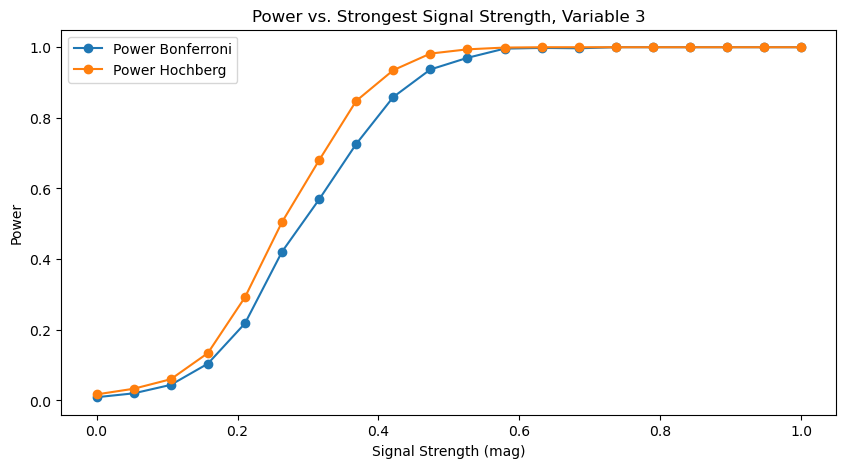

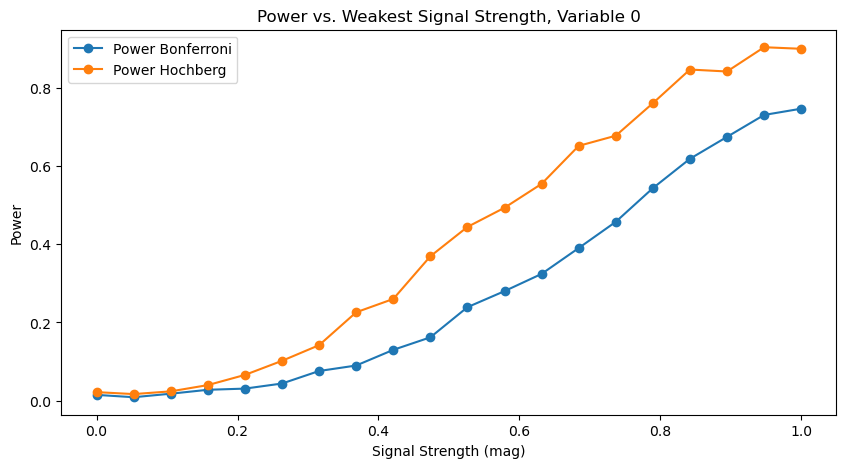

The difference originates from the fundamental differences of the p-values adjustment. Bonferroni method is a lot more conservative (of rejectinh the H0) while the Benjamini-Hochberg in contrary is more lenient and prone 'to find discoveries' (reject H0). As we can see in the two plots below the differences of the two methods are larger when having a weaker signal (variable 0) and smaller when having a strong signal. One might think of it as if the signal strength is 'outshining' the different p-values adjustment (The signal strength is to large for the adjustments to be very different).

The plot now confirms how the different methods in theory should work. Even though we've only run a simulation, not on real data. The Benjamini-Hochberg should theoretically, and have empirically, a stronger Power due to it's p-value adjustment being more prone to reject H0 and find discoveries.


In [16]:
import matplotlib.pyplot as plt

# Task 3e - Plot Power for the Strongest Signal
strongest_signal_index = np.argmax(betas[np.nonzero(betas)]) if np.any(betas) else 0

plt.figure(figsize=(10, 5))
plt.plot(magnitudes, Power_BF_3d[:, strongest_signal_index], label=f'Power Bonferroni', marker='o')
plt.plot(magnitudes, Power_Hochberg_3d[:, strongest_signal_index], label=f'Power Hochberg', marker='o')
plt.xlabel('Signal Strength (mag)')
plt.ylabel('Power')
plt.title(f'Power vs. Strongest Signal Strength, Variable {strongest_signal_index}')
plt.legend()
plt.show()

# Task 3e - Plot Power for the Weakest Signal
weakest_signal_index = np.argmin(betas[np.nonzero(betas)])  # Index of the weakest signal

plt.figure(figsize=(10, 5))
plt.plot(magnitudes, Power_BF_3d[:, weakest_signal_index], label=f'Power Bonferroni', marker='o')
plt.plot(magnitudes, Power_Hochberg_3d[:, weakest_signal_index], label=f'Power Hochberg', marker='o')
plt.xlabel('Signal Strength (mag)')
plt.ylabel('Power')
plt.title(f'Power vs. Weakest Signal Strength, Variable {weakest_signal_index}')
plt.legend()
plt.show()

why_difference_3e = "The difference originates from the fundamental differences of the p-values adjustment. Bonferroni method is a lot more conservative (of rejectinh the H0) while the Benjamini-Hochberg in contrary is more lenient and prone 'to find discoveries' (reject H0). As we can see in the two plots below the differences of the two methods are larger when having a weaker signal (variable 0) and smaller when having a strong signal. One might think of it as if the signal strength is 'outshining' the different p-values adjustment (The signal strength is to large for the adjustments to be very different).\n\nThe plot now confirms how the different methods in theory should work. Even though we've only run a simulation, not on real data. The Benjamini-Hochberg should theoretically, and have empirically, a stronger Power due to it's p-value adjustment being more prone to reject H0 and find discoveries."

print(why_difference_3e)

#### Task 3f)

Now plot the FWER rates for both Bonferroni and Benamini-Hochberg adjustments against the signal strength `mag`. 
Which pattern can you see in these lines? Write your answer into the string variable `what_pattern_3f`. 
What causes these patterns? Write your answer into the string variable `why_pattern_3f`. 

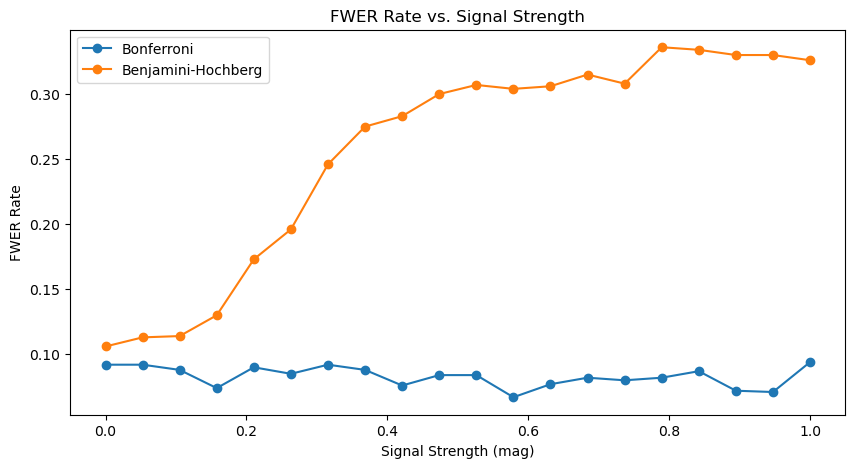


In the FWER rate vs. Signal Strength plot, we observe the following patterns:

Bonferroni method, as we discussed earlier is a conservative method that adjusts the p-values solely based on how many hypothesis test that are carried out simultaneously (alpha / N). When running this simulation the Bonferroni method should, in theory, have a stable non-increasing FWER. Thera is some movement, but this is due to the stochastic nature of the simulations.


Benjamini-Hochberg method/procedure on the other hand has a dynamic p-value adjustment (keep in mind that p-values are ordered from smallest to highest) where the method allows for a larger (which depends on the index of the ordered p-values) p-value to still be rejected for the 'latter tests'. What one then can figure out is that when the signal is stronger in combination with a more leninent decision rule the probability of rejecting a false H0 becomes larger --> FWER increases (and if the signal is weak from the begining the dynamic de

In [17]:
# Create line plot for FWER rates
plt.figure(figsize=(10, 5))

plt.plot(magnitudes, FWER_BF_3d, label='Bonferroni', marker='o')
plt.plot(magnitudes, FWER_Hochberg_3d, label='Benjamini-Hochberg', marker='o')

plt.xlabel('Signal Strength (mag)')
plt.ylabel('FWER Rate')
plt.title('FWER Rate vs. Signal Strength')
plt.legend()

plt.show()

# Explanation for the patterns
what_pattern_3f = """
In the FWER rate vs. Signal Strength plot, we observe the following patterns:\n
Bonferroni method, as we discussed earlier is a conservative method that adjusts the p-values solely based on how many hypothesis test that are carried out simultaneously (alpha / N). When running this simulation the Bonferroni method should, in theory, have a stable non-increasing FWER. Thera is some movement, but this is due to the stochastic nature of the simulations.\n\n
Benjamini-Hochberg method/procedure on the other hand has a dynamic p-value adjustment (keep in mind that p-values are ordered from smallest to highest) where the method allows for a larger (which depends on the index of the ordered p-values) p-value to still be rejected for the 'latter tests'. What one then can figure out is that when the signal is stronger in combination with a more leninent decision rule the probability of rejecting a false H0 becomes larger --> FWER increases (and if the signal is weak from the begining the dynamic decision-rule will still won't be able to reject it --> Weaker signal strength = Lower FWER). 
"""
print(what_pattern_3f)

## Part 4: Knock-off inference

In Mullainathan, Sendhil, and Jann Spiess. 2017. "Machine Learning: An Applied Econometric Approach." *Journal of Economic Perspectives*, 31 (2): 87-106, the authors compared several ML techniques for prediction of house prices (log of house prices). Here we will explore this data sets for variable selection (slightly cleaned by us a priori).
First we load the data.

In [18]:
ahs_data = pd.read_csv("asst7_data_part4.csv")
y_4a = ahs_data['y_4a']
X_4a = ahs_data.iloc[:,1:]
X_varnames_4a = X_4a.columns

### Task 4a)
As usual when working with lasso, we rescale the variances of all predictors and demean all variables before training any model. Do that here.

In [19]:
scaler_4a = StandardScaler(with_mean=False)
X_4a      = scaler_4a.fit_transform(X_4a)
y_4a      = scaler_4a.fit_transform(np.array(y_4a).reshape((len(y_4a), 1)))

### Task 4b)
Now use *scikit-learn* to perform ten-fold cross-validation and save the resulting object as `lasso_cv_4b`.

I have already written some code that saves the tuning parameter value selected through the one-S.E. rule as `alpha_1se`. Train a lasso model with this regularization parameter value and save this model as `lasso_fit_4b`. 

Lastly, extract the names of the selected variables (i.e. the variables corresponding to the non-zero coefficients of the lasso fit with chosen value for the regularization parameter $\lambda$) into an object `selected_names_4b` and save the total number of selected variables as `num_selected_4b`.

In [20]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import KFold

# Implement cross-validation
lasso_cv_4b = LassoCV(cv=10).fit(X_4a, y_4a.ravel())

# Get tuning parameter obtained with one-S.E. rule.
mean_mse      = np.mean(lasso_cv_4b.mse_path_, axis=1)
stderr_mse    = np.std(lasso_cv_4b.mse_path_, axis=1)
idx_alpha_1se = np.where(mean_mse <= (min(mean_mse) + stderr_mse))[0][-1]
alpha_1se     = lasso_cv_4b.alphas_[idx_alpha_1se]

# Train Lasso model with optimal tuning parameter 
lasso_fit_4b = Lasso(alpha=alpha_1se, fit_intercept=True).fit(X_4a[:,1:], y_4a.ravel()) # Fit intercept set to true. Here we only fit the data on X[:,1:] because the 1 column is all 0 when transformed in 4a).


# Extract non-zero coefficients
coef_nonzero      = np.where(lasso_fit_4b.coef_ != 0)[0]

selected_names_4b = X_varnames_4a[coef_nonzero]
num_selected_4b   = len(selected_names_4b)

print("Selected Feature Names:", selected_names_4b)
print("Number of Selected Features:", num_selected_4b)

Selected Feature Names: Index(['PHONEother', 'KITCHEN2', 'MOBILTYPother', 'WINTEROVENother',
       'WINTERELSPother', 'NEWC1', 'DISH2', 'WASH2', 'DRY2', 'REFR2',
       ...
       'OTHCLDother', 'NOWIREother', 'REGION2', 'REGION3', 'REGION4', 'METRO7',
       'METROother', 'UNITSFMISSother', 'EXCLUSMISS0', 'HOWHMISSother'],
      dtype='object', length=111)
Number of Selected Features: 111


### Task 4c) 
Next, we do controlled variable selection using knock-offs. In python, this is implemented via the `knockpy` package can be accessed through PyPI.
The central fucntion for conducting knock-off variable selection is `KnockoffFilter()`, whose [documentation](https://amspector100.github.io/knockpy/apiref.html) provides you with an overview of its capabilities.

First, call `KnockoffFilter()` to specify the setup of our variable selection exercise. More specifically, we want to base  
The statistic that we want to use to do variable selection is
$$
Z_i  =max \{\lambda:\beta_j(\lambda) \neq 0\},
$$
as suggested in the seminal paper of Candes and Barber (2015). We also use the fixed-X option for knockoffs. Save the resulting specification object as `knockoff_filter_4c`.

Second, apply the `forward()`-method to `knockoff_filter_4c` to run the knockoff filter. I order to select the correct arguments, recall that we want to select predictors of log houes prices `y_4a` from the whose set of predictor candidates `X_4a`. Now, we want to control the probability of making a mistake with an FDR of 15%.

Lastly, save the names of the selected variables in an object `selected_names_4c` and the number of selected variables as `number_selected_4c`. How does the number selected variables in Task 4b compare to the number that you have now? Write you answer into the string variable `num_selected_compare_4c`.

*Note:* The *knockpy* package deos not deal particularly well with large datasets. As a result, you might get a memory error. In this (likely) case, use fewer data points of `X_4a` and `y_4a`. To a certain degree, you can also free up unused memory using the `collect()` function in the `gc` package.

In [21]:
import knockpy as kpy

# 1.
knockoff_filter = kpy.KnockoffFilter(
    fstat = 'lasso', 
#    ksampler='fx'
)



# 2.
knockoff_result_4c = knockoff_filter.forward(
    X=X_4a,
    y = y_4a,
    fdr = 0.15)

# knockoff_filter.seqstep_plot() # Visualise

selected_names_4c = X_varnames_4a[knockoff_result_4c==1]
number_selected_4c = int(sum(knockoff_result_4c))

print("Selected Feature Names:", selected_names_4c)
print("Number of Selected Features:", number_selected_4c)

# 3. 
num_selected_compare_4c = f"There are {num_selected_4b - number_selected_4c} more features selected when running the ordinary LASSO. ({num_selected_4b - number_selected_4c} fewer when using the knockoff-filter method)."

print(num_selected_compare_4c)

Selected Feature Names: Index(['PHONEother', 'MOBILTYPother', 'WINTERELSPother', 'NEWC1', 'DISH2',
       'WASH2', 'DRY2', 'REFR2', 'BATHS', 'BEDRMS', 'DENS', 'FAMRM', 'HALFB',
       'KITCH', 'LIVING', 'BUILT', 'LOT', 'UNITSF', 'CLIMB', 'DIRAC',
       'AIRSYS2', 'WELDUSother', 'STEAM1', 'FRPLother', 'FPLWK2', 'FPINSother',
       'DISPL2', 'TRASH2', 'TYPEother', 'ENOEAPP2', 'ECNTAIR1', 'EAIRCother',
       'EHEATUT2', 'EHEATUTother', 'EFRIDGE2', 'EWASHR2', 'EWASHRother',
       'EDISHWR2', 'EDISHWRother', 'ETRSHCP2', 'AIR', 'NUMAIR',
       'SEWDISTPother', 'SEWDUSother', 'KEXCLUother', 'GARAGEother', 'BUSPER',
       'EXCLUS', 'LAUNDY', 'OTHRUN', 'DRSHOP2', 'CONDO3', 'CELLAR4',
       'CELLARother', 'WHNGET', 'FRSTOCother', 'PREOCCother', 'EBARother',
       'OTBUP1', 'OTBUP2', 'NUNITS', 'PLUGSother', 'OWNLOTother', 'ROOMS',
       'PLUMB2', 'ZADEQother', 'LEAKother', 'WTRHRLother', 'RATSother',
       'EGOODother', 'HOWH', 'BSINK2', 'TOILET2', 'ELEVWK1', 'EVROD2',
       'CRACKS2',

In [22]:
print("The script has been run succesfully.")

The script has been run succesfully.
